In [1]:
import requests
import os
import yaml
os.chdir('../')

In [26]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
params = {'legend.fontsize': 14,
          'figure.figsize': (15, 8),
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
plt.rcParams.update(params)
pd.options.display.max_columns = 50
pd.options.display.precision = 2

In [3]:
from cloudant.view import View
from cloudant.client import Cloudant
from cloudant.document import Document

In [4]:
def unfold_keys(df):
    df = df.copy()
    key_column = 'key'
    for i in range(0, len(df.loc[0,key_column])):
        df.insert(i, 'level_{}'.format(i+1), df[key_column].apply(lambda x: x[i]))
    del df[key_column]
    return df

In [5]:
with open("config.yaml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

In [6]:
cfg = cfg['COUCHDB']
client = Cloudant(cfg['user'], cfg['password'], url=cfg['host'])
client.connect()
db = client[cfg['tweets_db']]
ddoc = Document(db, '_design/sentiment_analysis')

In [7]:
view = View(ddoc, 'geo_sentiment_counts', )
with view.custom_result(group=True, stale='update_after', descending=True) as rslt:
    df = pd.DataFrame.from_records(rslt.all())

In [8]:
df['value'].sum()

105360

In [9]:
df.sort_values('value', ascending=False).head()

,key,value
288,"[None, None, None, None]",22888
285,"[None, None, None, Positive]",7390
286,"[None, None, None, Neutral]",6696
28,"[Sydney - South West, Greater Sydney, New Sout...",6366
160,"[Melbourne - Inner South, Greater Melbourne, V...",6131


In [10]:
geo_sentiment_columns = ['sa4_area', 'gccsa_area', 'state','sentiment', 'tweets_count']
data_df = unfold_keys(df)
data_df.columns = geo_sentiment_columns
data_df.sort_values('tweets_count', ascending=False, inplace=True)

In [13]:
data_df.set_index(geo_sentiment_columns[:-1], inplace=True)

In [19]:
sentiment_df = data_df.unstack(level=-1, fill_value=0)

In [12]:
#data_df.head()

In [33]:
sentiment_df.groupby(level='state').sum()

tweets_count                          
sentiment                             NaN Negative Neutral Positive
state                                                              
Australian Capital Territory            4      282     504      601
New South Wales                        35     4298    9048     9860
Northern Territory                      0       70     198      233
Other Territories                       0        0       0        1
Queensland                             24     1858    4001     4565
South Australia                         4      819    1735     1857
Tasmania                                0        0       2        1
Victoria                               44     3870    7740     8609
Western Australia                       9      920    2008     2100

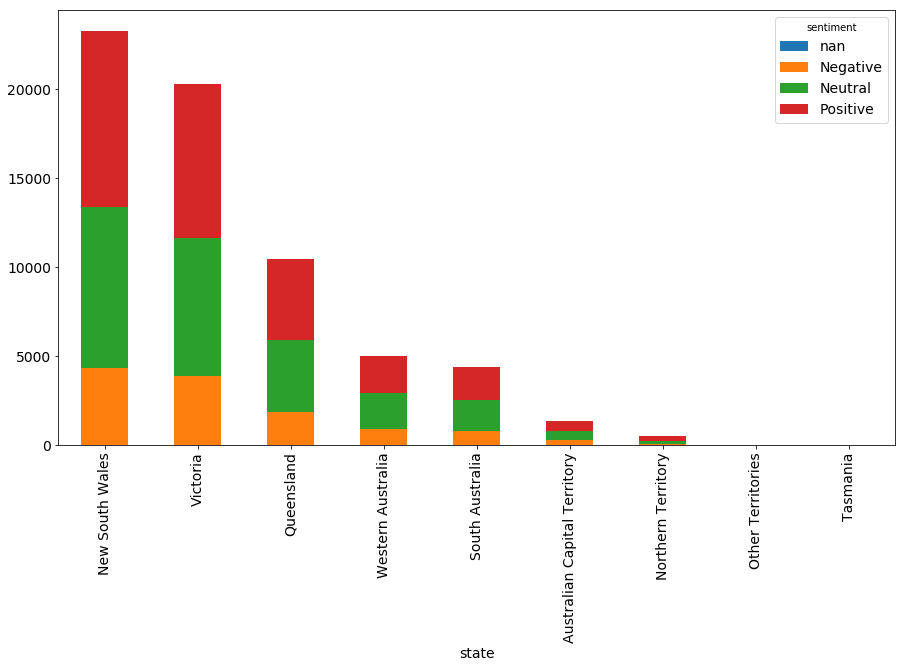

In [46]:
plot_df = sentiment_df.groupby(level='state').sum()
plot_df.columns = plot_df.columns.droplevel(0)
plot_df.sort_values('Positive', ascending=False, inplace=True)
plot_df.plot.bar(stacked=True)
plt.show()

In [ ]:
totals = plot_df.sum(axis=1)

In [ ]:
plot_df#/totals.T

sentiment,nan,Negative,Neutral,Positive
state,,,,
New South Wales,35,4298,9048,9860
Victoria,44,3870,7740,8609
Queensland,24,1858,4001,4565
Western Australia,9,920,2008,2100
South Australia,4,819,1735,1857
Australian Capital Territory,4,282,504,601
Northern Territory,0,70,198,233
Other Territories,0,0,0,1
Tasmania,0,0,2,1
